<a href="https://colab.research.google.com/github/evelinmus/cse120-2021-api/blob/main/Homework_3_Evelina_Musaelyan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
df = pd.read_csv('Country.csv')
data_dict = pd.read_csv('data-dictionary.csv')

##Task 1 :Data Sanity Checks

In [ ]:
df.shape

(167, 10)

In [ ]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
data_dict

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services. Given as %age o...
3,health,Total health spending as %age of Total GDP
4,imports,Imports of goods and services. Given as %age o...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


In [ ]:
# check for missing values
df.isna().sum()

,0
country,0
child_mort,0
exports,0
health,0
imports,0
income,0
inflation,0
life_expec,0
total_fer,0
gdpp,0


In [ ]:
df.isnull().sum()

,0
country,0
child_mort,0
exports,0
health,0
imports,0
income,0
inflation,0
life_expec,0
total_fer,0
gdpp,0


In [ ]:
# Count of duplicate rows
df.duplicated().sum()

0

In [ ]:
# Data types of each column
df.dtypes

,0
country,object
child_mort,float64
exports,float64
health,float64
imports,float64
income,int64
inflation,float64
life_expec,float64
total_fer,float64
gdpp,int64


In [ ]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols

['child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

In [ ]:
# check if any num_col is negative. Only inflation is negative which is okay.
df[df[num_cols]<0].sum()

,0
country,0
child_mort,0.0
exports,0.0
health,0.0
imports,0.0
income,0.0
inflation,-12.998
life_expec,0.0
total_fer,0.0
gdpp,0.0


## Task 2:Data Preparation

In [ ]:
# a) Create a trade balance feature (difference between exports and imports)
#    Both are % of GDP, so this feature shows whether a country is export- or import-heavy.
df["trade_balance"] = df["exports"] - df["imports"]

In [ ]:
#Compare Income to GDP per capita
df["income_to_gdpp"] = np.where(df["gdpp"] == 0,
                                    np.nan,
                                    df["income"] / df["gdpp"])

In [ ]:
# Create a binary flag for high inflation (e.g., > 5%)
df["high_inflation"] = (df["inflation"] > 5).astype(int)

In [ ]:
# Create a categorical variable based on trade_balance:
# "Surplus" if exports exceed imports, "Deficit" if imports exceed exports,
# and "Balanced" if they are roughly equal (within a small threshold).
def trade_category(x, threshold=0.5):
    if x > threshold:
        return "Surplus"
    elif x < -threshold:
        return "Deficit"
    else:
        return "Balanced"

if "trade_balance" in df.columns:
    df["trade_balance_category"] = df["trade_balance"].apply(trade_category)

In [ ]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,trade_balance,income_to_gdpp,high_inflation,trade_balance_category
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,-34.9,2.911392,1,Deficit
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,-20.6,2.427873,0,Deficit
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,7.0,2.892377,1,Surplus
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,19.4,1.671388,1,Surplus
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,-13.4,1.565574,0,Deficit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,-6.1,0.993266,0,Deficit
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,10.9,1.222222,1,Surplus
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,-8.2,3.427481,1,Deficit
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,-4.4,3.419847,1,Deficit


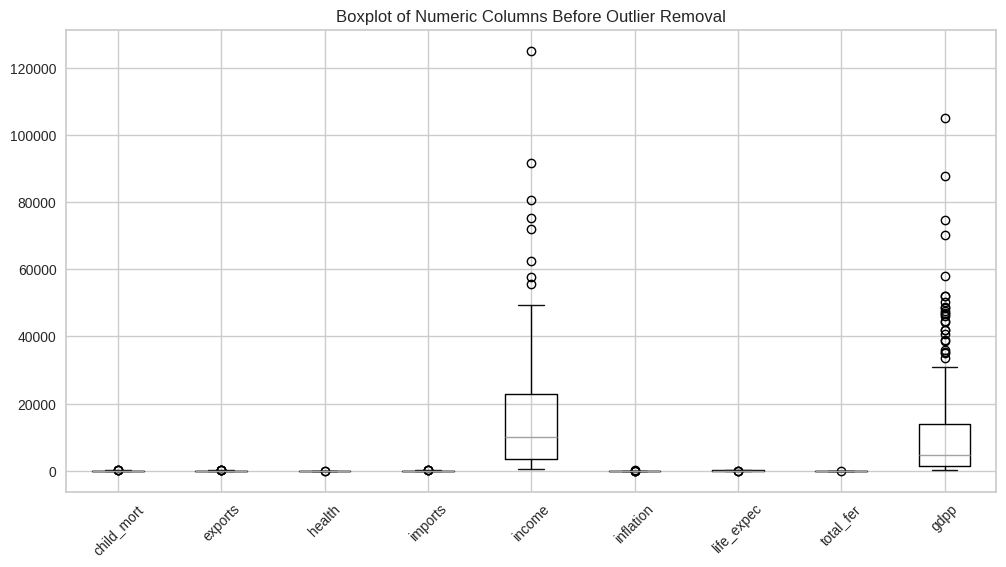

In [ ]:
# (Optional) Visual check for outliers via boxplots
plt.figure(figsize=(12, 6))
df[num_cols].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of Numeric Columns Before Outlier Removal")
plt.show()

# Save initial shape for reference
initial_shape = df.shape

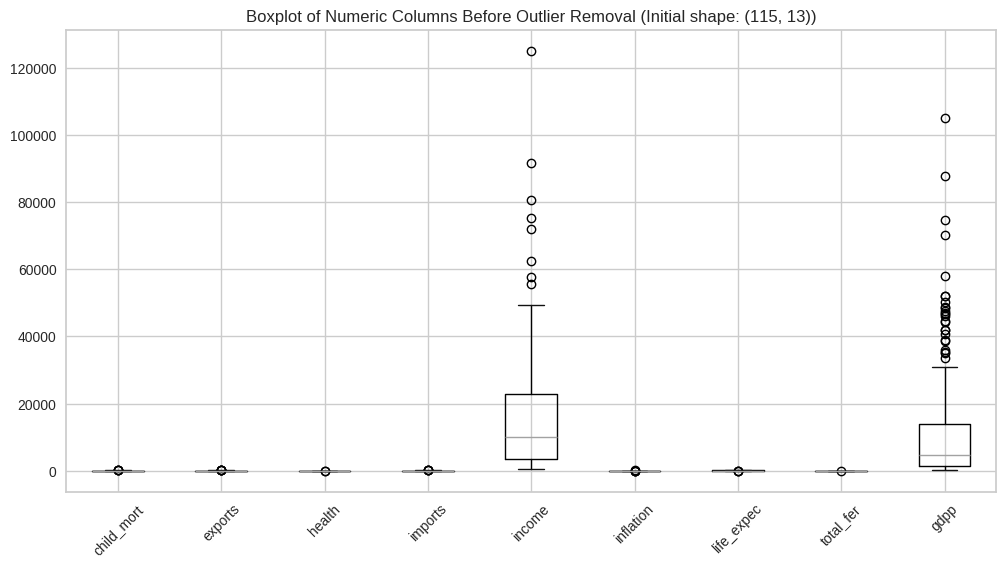

In [ ]:
#Visual check for outliers via boxplots after removal
plt.figure(figsize=(12, 6))
df[num_cols].boxplot()
plt.xticks(rotation=45)
plt.title(f"Boxplot of Numeric Columns Before Outlier Removal (Initial shape: {final_shape})")
plt.show()


## Task 3: Exploratory Data Analysis

In [ ]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,trade_balance,income_to_gdpp,high_inflation
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,-5.781239,2.005033,0.508982
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809,18.942578,0.750782,0.501423
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000,-73.500000,0.513889,0.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,-14.850000,1.496382,0.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,-4.800000,2.013699,1.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,3.850000,2.483232,1.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,39.400000,4.115385,1.000000


In [ ]:
# (A) Grouping by high inflation status
print("Grouped Summary Statistics by High Inflation (0: Low, 1: High):")
grouped_inflation = df.groupby("high_inflation").agg({
    "child_mort": ["mean", "median", "std"],
    "exports": ["mean", "median"],
    "imports": ["mean", "median"],
    "inflation": ["mean", "median"],
    "life_expec": ["mean", "median"],
    "total_fer": ["mean", "median"],
    "gdpp": ["mean", "median"]
})
print(grouped_inflation)

Grouped Summary Statistics by High Inflation (0: Low, 1: High):
               child_mort                      exports           imports  \
                     mean median        std       mean median       mean   
high_inflation                                                             
0               26.963415   10.7  35.671216  45.708537   37.3  53.708537   
1               49.177647   35.4  41.736570  36.671753   32.9  40.312540   

                       inflation         life_expec        total_fer         \
               median       mean  median       mean median      mean median   
high_inflation                                                                
0               50.25   1.812146   1.755  73.304878   76.3  2.521585  1.955   
1               35.00  13.540824  10.600  67.903529   69.6  3.359294  2.660   

                        gdpp          
                        mean  median  
high_inflation                        
0               18366.121951  8545.0  
1  

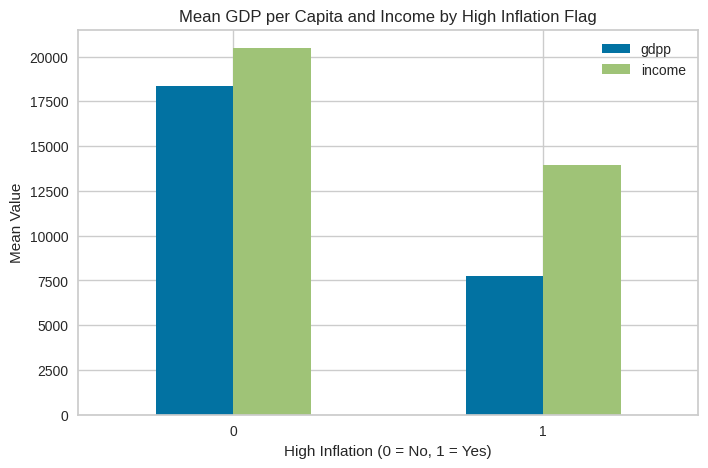

In [ ]:
# Visualize mean GDP per capita and Income (if available) by high_inflation flag
grouped_vals = df.groupby("high_inflation")[["gdpp", "income"]].mean()
grouped_vals.plot(kind="bar", figsize=(8, 5))
plt.title("Mean GDP per Capita and Income by High Inflation Flag")
plt.xlabel("High Inflation (0 = No, 1 = Yes)")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# (B) Grouping by Trade Balance Category
print("\nGrouped Summary Statistics by Trade Balance Category:")
grouped_trade = df.groupby("trade_balance_category").agg({
      "child_mort": ["mean", "median", "std"],
      "exports": ["mean", "median"],
      "imports": ["mean", "median"],
      "gdpp": ["mean", "median"],
      "income": ["mean", "median"]})
print(grouped_trade)


Grouped Summary Statistics by Trade Balance Category:
                       child_mort                      exports           \
                             mean median        std       mean   median   
trade_balance_category                                                    
Balanced                34.950000  34.95  41.648589  18.854500  18.8545   
Deficit                 45.832381  28.10  43.024100  32.912286  29.2000   
Surplus                 25.146667  11.25  31.724366  56.195000  51.9000   

                          imports                    gdpp           \
                             mean    median          mean   median   
trade_balance_category                                               
Balanced                19.082950  19.08295   7244.000000   7244.0   
Deficit                 48.915238  46.60000   7245.009524   2970.0   
Surplus                 44.273333  37.90000  23163.333333  13000.0   

                              income           
                         

<ipython-input-323-96f88ba4a4a2>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




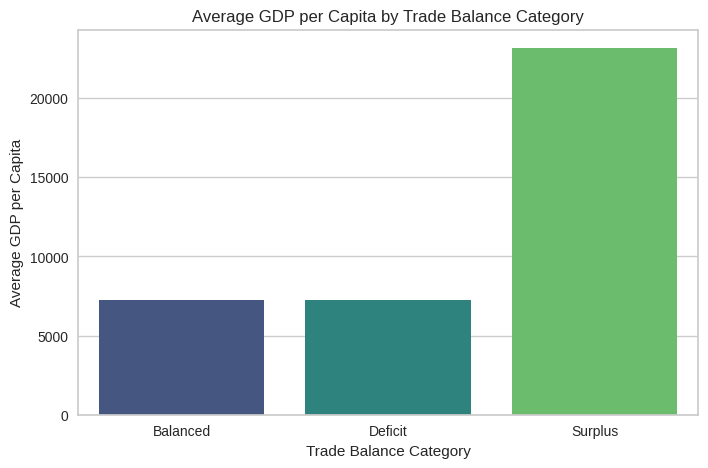

In [ ]:
    # Visualize the average GDP per capita by trade balance category
    grouped_trade_vis = df.groupby("trade_balance_category")["gdpp"].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x="trade_balance_category", y="gdpp", data=grouped_trade_vis, palette="viridis")
    plt.title("Average GDP per Capita by Trade Balance Category")
    plt.xlabel("Trade Balance Category")
    plt.ylabel("Average GDP per Capita")
    plt.show()


## Task 4: K-Means Clustering (Determining Optimal k)

In [ ]:
features = df.drop(columns=["country"])

In [ ]:
# Select only numeric columns (assuming all remaining columns are numeric)
df_num= features.select_dtypes(include=[np.number])

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

In [ ]:
# Elbow Method: Calculate WCSS for k from 1 to 10
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

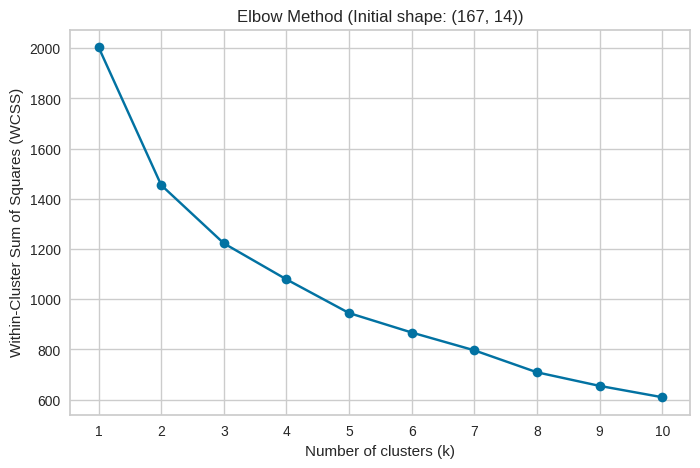

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title(f"Elbow Method (Initial shape: {df.shape})")
plt.xticks(K_range)
plt.show()

In [ ]:
# Silhouette Analysis: Compute Silhouette Score for k from 2 to 10
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

ValueError: x and y must have same first dimension, but have shapes (7,) and (9,)

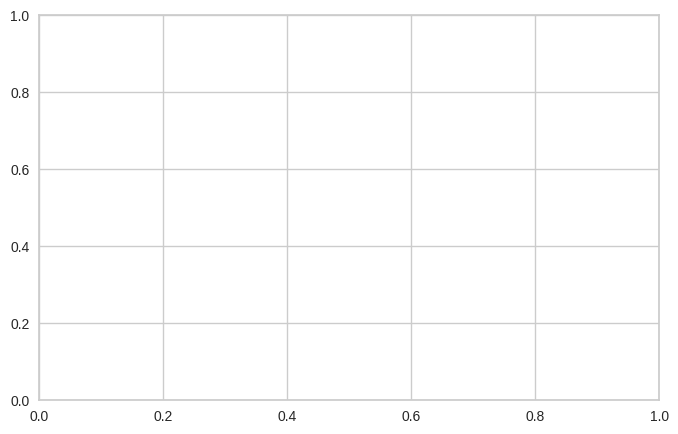

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 9), silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis For Determining Optimal k")
plt.xticks(range(2, 9))
plt.show()

In [ ]:
km_yb = KMeans(n_clusters=2, random_state=42)
visualizer = SilhouetteVisualizer(km_yb, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.poof()

In [ ]:
km_yb = KMeans(n_clusters=3, random_state=42)
visualizer = SilhouetteVisualizer(km_yb, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.poof()

In [ ]:
km_yb = KMeans(n_clusters=4, random_state=42)
visualizer = SilhouetteVisualizer(km_yb, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.poof()

In [ ]:
km_yb = KMeans(n_clusters=5, random_state=42)
visualizer = SilhouetteVisualizer(km_yb, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.poof()

## 5. Explain the clusters

In [ ]:
# Based on elbow and silhouette analysis, I selected k = 3

In [ ]:
# Performed hierarchical clustering using Ward's method.
Z = linkage(X_scaled, method='ward')

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(X_scaled)
df_num["Segment_k"] = kmeans.labels_

In [ ]:
df_s = df_num.groupby(['Segment_k']).mean()
df_s

Segment 0
Child Mortality (30) and Life Expectancy (≈76) are around moderate levels.
GDP per capita (≈7,029) and Income (≈10,851) suggest a middle-income segment.
Inflation (8.29%) is relatively high compared to the other segments, leading to about half the countries in this segment exceeding 5% inflation.
Health spending (2.69%) is the lowest among the three, but still a non-negligible share of GDP.
Trade Balance (−2.14) indicates these countries import slightly more than they export (negative but not the largest deficit).
Overall: These are middle-tier economies with moderate development indicators and somewhat higher inflation levels.

Segment 1
Child Mortality (40) is the highest of the three segments, and Life Expectancy (≈69) is the lowest.
GDP per capita (≈3,962) and Income (≈7,283) are the lowest, suggesting poorer countries overall.
Health spending (3.34%) is moderate, higher than Segment 0 but lower than Segment 2.
Inflation (2.42%) is relatively low, with only about 25% of countries experiencing >5% inflation.
Total Fertility (3.20) is the highest, indicating larger average family sizes.
Trade Balance (−3.08) is the most negative, suggesting a heavier reliance on imports relative to exports.
Overall: These countries show lower economic development and higher demographic pressure (high child mortality, high fertility), but relatively stable inflation.

Segment 2
Child Mortality (21) is the lowest, and Life Expectancy (≈78) is the highest.
GDP per capita (≈12,603) and Income (≈17,470) are the highest, suggesting wealthier or more developed economies.
Health spending (3.62%) is also the highest, aligning with better health outcomes.
Inflation (2.48%) is moderate, and only about 15% of countries in this segment exceed 5% inflation.
Total Fertility (2.31) is the lowest, typically seen in more developed nations.
Trade Balance (−2.80) is negative but not as large as Segment 1.
Overall: These countries tend to be more affluent, have better health indicators, lower child mortality, and longer life expectancy, with relatively stable inflation.

In [ ]:
for col in df_s.columns:
    fig = px.bar(
        df_s.reset_index(),
        x="Segment_k",
        y=col,
        title=f"Mean {col} by Segment",
        labels={"Segment_k": "Segment", col: f"Mean {col}"},
        color="Segment_k",  # Color by segment for better visualization
        )
    fig.show()

## Task 6 Implement PCA dimensionality reduction- explain the chosen number of pc components

In [ ]:
# Run PCA and calculate cumulative explained variance
pca = PCA().fit(X_scaled)
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.xticks(range(1, len(cum_var) + 1))
plt.show()

In [ ]:
# Use all numeric columns for PCA
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # This will have 12 columns
X = df[num_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA with optimal_components determined previously (here assumed to be 6)
pca_optimal = PCA(n_components=optimal_components)
X_pca = pca_optimal.fit_transform(X_scaled)

# Create a DataFrame for the PCA loadings (component coefficients)
loadings = pd.DataFrame(
    pca_optimal.components_.T,
    index=num_cols,
    columns=[f"PC{i+1}" for i in range(optimal_components)]
)
print("\nPCA Loadings (Feature Importance per Component):")
print(loadings)

From the cumulative explained variance plot, we see that the first 6 principal components together capture at least 90% of the total variance in our dataset. Adding more components (7, 8, etc.) would only incrementally increase the explained variance while making the model more complex. Therefore, using 6 principal components strikes a balance between:

Dimensionality Reduction: Reducing the original set of features to a smaller, more manageable number of components.
Information Retention: Retaining the vast majority of the variance (information) in the data

## 7. Interpret the pca results in terms of column importance

PC1 primarily contrasts countries by overall prosperity and health. Higher loadings for GDP per capita, income, and life expectancy appear on the positive side, while child mortality and total fertility have negative loadings. This suggests that wealthier, healthier nations lie at one end, whereas poorer, higher-fertility countries lie at the opposite end.

PC2 highlights differences in trade orientation and fertility. Exports and income load positively, whereas total fertility and inflation load negatively. Countries with robust trade and higher income separate from those with larger families and higher inflation concerns.

PC3 captures a mix of trade balance and inflation patterns. Positive loadings for trade_balance and inflation suggest these countries run surpluses with rising prices, while negative loadings on other features point to contrasting economic or demographic profiles.

PC4 ties together child mortality, fertility, and aspects of trade/income. Higher child mortality and total fertility appear alongside positive trade_balance and income_to_gdpp, implying a unique blend of demographic pressures and trade/income characteristics.

PC5 emphasizes trade balance and the income-to-GDP ratio versus inflation. Strong positive loadings on trade_balance and income_to_gdpp contrast with a negative loading on inflation, separating stable-trade, higher-income countries from those with inflationary tendencies.

PC6 is driven mainly by inflation measures. Positive loadings for inflation and high_inflation indicate this component differentiates countries with significant price growth from those with lower inflation rates.







## 8. Re-do k-means clustering based on created PC components

In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
optimal_clusters = 3

In [ ]:
kmeans_pca = KMeans(n_clusters=optimal_clusters, random_state=42)
pca_labels = kmeans_pca.fit_predict(X_pca)

In [ ]:
df_num['Cluster_PCA'] = pca_labels

In [ ]:
#Examine the cluster means in terms of the original features
df_pca_means = df_num.groupby('Cluster_PCA').mean()
print("Mean values of original features by PCA-based cluster:")
display(df_pca_means)

## 9. Explain the clusters
## a. Describe the clusters and try to create country profiles based on it
## b. Implement UMAP visualization of data and color data points based on clusters.